Get the prerequisites done

In [ ]:
!pip freeze | grep "tensorflow\|keras\|pydot"

keras-nightly==2.5.0.dev2021032900
keras-vis==0.4.1
pydot==1.3.0
pydot-ng==2.0.0
pydotplus==2.0.2
tensorflow @ file:///tensorflow-2.5.0-cp37-cp37m-linux_x86_64.whl
tensorflow-datasets==4.0.1
tensorflow-estimator==2.5.0
tensorflow-gcs-config==2.5.0
tensorflow-hub==0.12.0
tensorflow-metadata==1.1.0
tensorflow-probability==0.13.0


In [ ]:
#import config
import math
import numpy as np
from tensorflow.keras import backend as K

def anchor_sizes(n_layers=4):
    """Generate linear distribution of sizes depending on 
    the number of ssd top layers

    Arguments:
        n_layers (int): Number of ssd head layers

    Returns:
        sizes (list): A list of anchor sizes
    """
    s = np.linspace(0.2, 0.9, n_layers + 1)
    sizes = []
    for i in range(len(s) - 1):
        # size = [s[i], (s[i] * 0.5)]
        size = [s[i], math.sqrt(s[i] * s[i + 1])]
        sizes.append(size)

    return sizes # s[0] is scale size, s[1] is sqrt(scale*(scale+1))

In [ ]:
anchor_sizes(4)

[[0.2, 0.2738612787525831],
 [0.375, 0.4541475531146238],
 [0.55, 0.6314665470157543],
 [0.7249999999999999, 0.8077747210701756]]

In [ ]:
def anchor_boxes(feature_shape,
                 image_shape,
                 index=0,
                 n_layers=4,
                 aspect_ratios=(1, 2, 0.5)):
    """ Compute the anchor boxes for a given feature map.
    Anchor boxes are in minmax format

    Arguments:
        feature_shape (list): Feature map shape
        image_shape (list): Image size shape
        index (int): Indicates which of ssd head layers
            are we referring to
        n_layers (int): Number of ssd head layers

    Returns:
        boxes (tensor): Anchor boxes per feature map
    """
    
    # anchor box sizes given an index of layer in ssd head
    sizes = anchor_sizes(n_layers)[index]
    # number of anchor boxes per feature map pt
    n_boxes = len(aspect_ratios) + 1
    # ignore number of channels (last)
    image_height, image_width, _ = image_shape
    # ignore number of feature maps (last)
    feature_height, feature_width, _ = feature_shape

    # normalized width and height
    # sizes[0] is scale size, sizes[1] is sqrt(scale*(scale+1))
    norm_height = image_height * sizes[0]
    norm_width = image_width * sizes[0]

    # list of anchor boxes (width, height)
    width_height = []
    # anchor box by aspect ratio on resized image dims
    # Equation 11.2.3 
    for ar in aspect_ratios:
        box_width = norm_width * np.sqrt(ar)
        box_height = norm_height / np.sqrt(ar)
        width_height.append((box_width, box_height))
    # multiply anchor box dim by size[1] for aspect_ratio = 1
    # Equation 11.2.4
    box_width = image_width * sizes[1]
    box_height = image_height * sizes[1]
    width_height.append((box_width, box_height))

    # now an array of (width, height)
    width_height = np.array(width_height)

    # dimensions of each receptive field in pixels
    grid_width = image_width / feature_width
    grid_height = image_height / feature_height

    # compute center of receptive field per feature pt
    # (cx, cy) format 
    # starting at midpoint of 1st receptive field
    start = grid_width * 0.5 
    # ending at midpoint of last receptive field
    end = (feature_width - 0.5) * grid_width
    cx = np.linspace(start, end, feature_width)

    start = grid_height * 0.5
    end = (feature_height - 0.5) * grid_height
    cy = np.linspace(start, end, feature_height)

    # grid of box centers
    cx_grid, cy_grid = np.meshgrid(cx, cy)

    # for np.tile()
    cx_grid = np.expand_dims(cx_grid, -1) 
    cy_grid = np.expand_dims(cy_grid, -1)

    # tensor = (feature_map_height, feature_map_width, n_boxes, 4)
    # aligned with image tensor (height, width, channels)
    # last dimension = (cx, cy, w, h)
    boxes = np.zeros((feature_height, feature_width, n_boxes, 4))
    
    # (cx, cy)
    boxes[..., 0] = np.tile(cx_grid, (1, 1, n_boxes))
    boxes[..., 1] = np.tile(cy_grid, (1, 1, n_boxes))

    # (w, h)
    boxes[..., 2] = width_height[:, 0]
    boxes[..., 3] = width_height[:, 1]

    # convert (cx, cy, w, h) to (xmin, xmax, ymin, ymax)
    # prepend one dimension to boxes 
    # to account for the batch size = 1
    boxes = centroid2minmax(boxes)
    boxes = np.expand_dims(boxes, axis=0)
    return boxes

In [ ]:
n_layers = 2 #Number of ssd head layers
index = 0 #indicates which of ssd head layers are we referring to

In [ ]:
sizes = anchor_sizes(n_layers)[index] # different sizes of grid (1/2, 1), (1/3,1/2) etc..

In [ ]:
sizes

[0.2, 0.33166247903554]

In [ ]:
aspect_ratios = (1, 2, 0.5)

In [ ]:
n_boxes = len(aspect_ratios) + 1 # number of anchor boxes per feature map and the additional box 

In [ ]:
n_boxes

4

In [ ]:
image_height, image_width, _ = 640, 480, 3 # ignore channels

In [ ]:
feature_height, feature_width, _ = 7, 7, 512 # shape of activations? # ignore number of feature maps (last)

### why is this sizes[0]?
Because sizes[1] is just for the additional box. sizes[0] has the actual scaling factor. Here sx=sy stored in sizes[0]

In [24]:
    # normalized width and height
    # sizes[0] is scale size, sizes[1] is sqrt(scale*(scale+1))
    norm_height = image_height * sizes[0]
    norm_width = image_width * sizes[0] 

In [25]:
norm_height, norm_width

(128.0, 96.0)

In [26]:
    # list of anchor boxes (width, height)
    width_height = []
    # anchor box by aspect ratio on resized image dims
    # Equation 11.2.3 
    for ar in aspect_ratios:
        box_width = norm_width * np.sqrt(ar)
        box_height = norm_height / np.sqrt(ar)
        width_height.append((box_width, box_height))

In [27]:
width_height # grid sizes for a given size of \grid

[(96.0, 128.0),
 (135.76450198781714, 90.50966799187808),
 (67.88225099390857, 181.01933598375615)]

Additional box for the aspect ratio 1

In [28]:
box_width = image_width * sizes[1]
box_height = image_height * sizes[1] # multiply anchor box dim by size[1] for aspect_ratio = 1
width_height.append((box_width, box_height)) 

In [29]:
width_height

[(96.0, 128.0),
 (135.76450198781714, 90.50966799187808),
 (67.88225099390857, 181.01933598375615),
 (159.19798993705922, 212.26398658274562)]

In [30]:
width_height = np.array(width_height)
width_height

array([[ 96.        , 128.        ],
       [135.76450199,  90.50966799],
       [ 67.88225099, 181.01933598],
       [159.19798994, 212.26398658]])

### Find out the size of receptive field as ratio of image dim and output feature size: 640/7 480/7

This basically finds the size of each grid cell in the input image.

In [32]:
    # dimensions of each receptive field in pixels
    grid_width = image_width / feature_width
    grid_height = image_height / feature_height
    grid_width, grid_height

(68.57142857142857, 91.42857142857143)

Find location of each grid cell x and y based on this

In [70]:
    # compute center of receptive field per feature pt
    # (cx, cy) format 
    # starting at midpoint of 1st receptive field
    start = grid_width * 0.5 
    # ending at midpoint of last receptive field
    end = (feature_width - 0.5) * grid_width # 0.5 is safety margin to not print last size 

In [71]:
start, end

(34.285714285714285, 445.7142857142857)

Starting points of x of each grid cell

In [67]:
np.linspace(start, end, feature_width)

array([ 34.28571429, 102.85714286, 171.42857143, 240.        ,
       308.57142857, 377.14285714, 445.71428571])

Similarly for y

In [68]:
    cx = np.linspace(start, end, feature_width)

    start = grid_height * 0.5
    end = (feature_height - 0.5) * grid_height
    cy = np.linspace(start, end, feature_height)
    cx, cy

(array([ 34.28571429, 102.85714286, 171.42857143, 240.        ,
        308.57142857, 377.14285714, 445.71428571]),
 array([ 45.71428571, 137.14285714, 228.57142857, 320.        ,
        411.42857143, 502.85714286, 594.28571429]))

In [69]:
 np.meshgrid?

Returns a tuple of positions indicating the **center-coordinates** of each grid cell

In [73]:
np.meshgrid(cx, cy)

[array([[ 34.28571429, 102.85714286, 171.42857143, 240.        ,
         308.57142857, 377.14285714, 445.71428571],
        [ 34.28571429, 102.85714286, 171.42857143, 240.        ,
         308.57142857, 377.14285714, 445.71428571],
        [ 34.28571429, 102.85714286, 171.42857143, 240.        ,
         308.57142857, 377.14285714, 445.71428571],
        [ 34.28571429, 102.85714286, 171.42857143, 240.        ,
         308.57142857, 377.14285714, 445.71428571],
        [ 34.28571429, 102.85714286, 171.42857143, 240.        ,
         308.57142857, 377.14285714, 445.71428571],
        [ 34.28571429, 102.85714286, 171.42857143, 240.        ,
         308.57142857, 377.14285714, 445.71428571],
        [ 34.28571429, 102.85714286, 171.42857143, 240.        ,
         308.57142857, 377.14285714, 445.71428571]]),
 array([[ 45.71428571,  45.71428571,  45.71428571,  45.71428571,
          45.71428571,  45.71428571,  45.71428571],
        [137.14285714, 137.14285714, 137.14285714, 137.1428571

In [74]:
cx_grid, cy_grid = np.meshgrid(cx, cy)

In [77]:
from matplotlib import pyplot as plt

These are the centers of the grid cell in the input image, according to the receptive field size

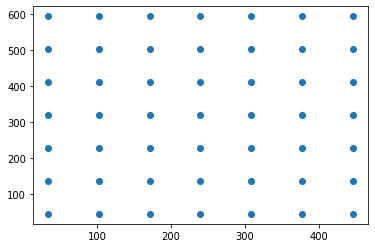

In [82]:
plt.scatter(cx_grid,cy_grid) 

In [83]:
    # for np.tile()
    cx_grid = np.expand_dims(cx_grid, -1)  # like unsqueeze
    cy_grid = np.expand_dims(cy_grid, -1)

In [84]:
feature_height*feature_width*n_boxes

196

In [85]:
boxes = np.zeros((feature_height, feature_width, n_boxes, 4)) # 4 coordinates per box

In [86]:
boxes.shape

(7, 7, 4, 4)

## Construct an array by repeating A the number of times given by reps.

np.tile(A, reps)

In [89]:
cx_grid.shape

(7, 7, 1)

In [92]:
    # (cx, cy)
    boxes[..., 0] = np.tile(cx_grid, (1, 1, n_boxes))
    boxes[..., 1] = np.tile(cy_grid, (1, 1, n_boxes))

In [93]:
 boxes[..., 0].shape

(7, 7, 4)

In [95]:
 boxes

array([[[[ 34.28571429,  45.71428571,   0.        ,   0.        ],
         [ 34.28571429,  45.71428571,   0.        ,   0.        ],
         [ 34.28571429,  45.71428571,   0.        ,   0.        ],
         [ 34.28571429,  45.71428571,   0.        ,   0.        ]],

        [[102.85714286,  45.71428571,   0.        ,   0.        ],
         [102.85714286,  45.71428571,   0.        ,   0.        ],
         [102.85714286,  45.71428571,   0.        ,   0.        ],
         [102.85714286,  45.71428571,   0.        ,   0.        ]],

        [[171.42857143,  45.71428571,   0.        ,   0.        ],
         [171.42857143,  45.71428571,   0.        ,   0.        ],
         [171.42857143,  45.71428571,   0.        ,   0.        ],
         [171.42857143,  45.71428571,   0.        ,   0.        ]],

        [[240.        ,  45.71428571,   0.        ,   0.        ],
         [240.        ,  45.71428571,   0.        ,   0.        ],
         [240.        ,  45.71428571,   0.        ,   0.

In [96]:
width_height

array([[ 96.        , 128.        ],
       [135.76450199,  90.50966799],
       [ 67.88225099, 181.01933598],
       [159.19798994, 212.26398658]])

In [97]:
width_height[:, 0]

array([ 96.        , 135.76450199,  67.88225099, 159.19798994])

In [98]:
    # (w, h)
    boxes[..., 2] = width_height[:, 0]
    boxes[..., 3] = width_height[:, 1]

In [99]:
    # convert (cx, cy, w, h) to (xmin, xmax, ymin, ymax)
    # prepend one dimension to boxes 
    # to account for the batch size = 1
    #boxes = centroid2minmax(boxes) # for voc only
    boxes = np.expand_dims(boxes, axis=0)

In [100]:
boxes

array([[[[[ 34.28571429,  45.71428571,  96.        , 128.        ],
          [ 34.28571429,  45.71428571, 135.76450199,  90.50966799],
          [ 34.28571429,  45.71428571,  67.88225099, 181.01933598],
          [ 34.28571429,  45.71428571, 159.19798994, 212.26398658]],

         [[102.85714286,  45.71428571,  96.        , 128.        ],
          [102.85714286,  45.71428571, 135.76450199,  90.50966799],
          [102.85714286,  45.71428571,  67.88225099, 181.01933598],
          [102.85714286,  45.71428571, 159.19798994, 212.26398658]],

         [[171.42857143,  45.71428571,  96.        , 128.        ],
          [171.42857143,  45.71428571, 135.76450199,  90.50966799],
          [171.42857143,  45.71428571,  67.88225099, 181.01933598],
          [171.42857143,  45.71428571, 159.19798994, 212.26398658]],

         [[240.        ,  45.71428571,  96.        , 128.        ],
          [240.        ,  45.71428571, 135.76450199,  90.50966799],
          [240.        ,  45.71428571,  67